In [1]:
from IPython.display import Image

## Intro

The predictions from Bayesian inference are probability distributions rather than point estimates, this allows for the quantification of uncertainty in the inferences that are made, which is often missing from the predictions made by machine learning methods. It is not practical to analytically compute the required distributions, and stochastic sampling methods such as Markov chain Monte Carlo (MCMC) are used instead. One way of implementing MCMC methods in a transparent and efficient way is via the probabilistic programming language, Stan.

## Bayes’ Theorem
The crux of Bayesian inference is in Bayes’ theorem:

<img src="https://cdn-images-1.medium.com/max/1600/1*Yv9hPcqX5LMQvyt98OWLKA.png" width="300">

That thing on the left is our posterior, which is the distribution we’re interested in. On the right-hand side, we have the likelihood, which is dependent on our model and data, multiplied by the prior, which represents our pre-existing beliefs, and divided by the marginal likelihood which normalises the distribution.

## MCMC

That P(B) up there involves an integral over all possible values that the model parameters can take. Luckily, we’re not totally at a loss, as it is possible to construct an approximation to the posterior distribution by drawing samples from it, and creating a histogram of those sampled values to serve as the desired posterior.

In generating those samples, we need a methodological framework to govern how the sampler should move through the parameter space. A popular choice is Markov chain Monte Carlo. MCMC is a class of methods that combines two powerful concepts: Markov chains and Monte Carlo sampling.

Markov chains are stochastic processes that evolve over time in a “memoryless” way, known as the Markov property. The Markov property means that the state of a Markov chain transitions to another state with a probability that depends only on the most recent state of the system, and not its entire history.

Monte Carlo sampling, on other hand, involves solving deterministic problems by repeated random sampling. The canonical way of doing this is with the Metropolis-Hastings algorithm.

Stan instead generates these samples using a state-of-the-art algorithm known as Hamiltonian Monte Carlo (HMC), which builds upon the Metropolis-Hastings algorithm by incorporating many theoretical ideas from physics. Actually, by default it implements a version of HMC called the No-U-Turn Sampler (NUTS).

## Example: Univariate Linear Regression
The model we’ll implement is:
<img src="https://cdn-images-1.medium.com/max/1600/1*zCShpfMhqPRGa9H_vMKpKQ.png" width="300">

where we have an intercept α and a gradient β, and our data is distributed about this straight line with Gaussian noise of standard deviation σ.

## Stan 

A Stan model requires at least three blocks, for each of data, parameters, and the model. The data block specifies the types and dimensions of the data that will be used for sampling, and the parameter block specifies the relevant parameters. The distribution statement goes in the model block, which in our case is a straight line with additional Gaussian noise. Though not included here, it is also possible to specify transformed data and transformed parameter blocks, as well as blocks for functions and generated quantities.

Notice that in the parameter block, we’ve specified the lower bound for sigma as 0, as it’s impossible for the magnitude of Gaussian noise to be negative. This is an example of a prior on the parameter sigma, and more detailed priors can be added in the model block.

Notice also that we’re not adding any priors to our alpha and beta parameters, though feel free to experiment with adding priors in the model block and see how they affect the posterior estimates.

In [3]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

## Data generation

Here we will specify the ‘ground truth’ values of our parameters which we’ll aim to reproduce using Stan, and generate data from these parameters using numpy, making sure to add Gaussian noise.

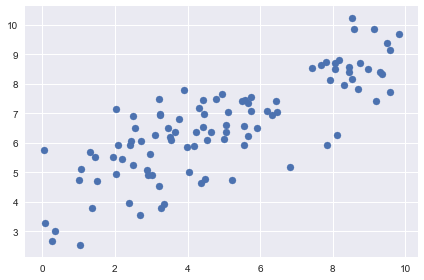

In [8]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

plt.scatter(x,y)
plt.tight_layout()

## Sampling
Within the sampling method, there are a number of parameters that can be specified. iter refers to the total number of samples that will be generated from each Markov chain, and chains is the number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample.

warmup, also known as 'burn-in' is the amount of samples that will be discarded from the beginning of each chain, as the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium.

By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.

thin specifies an interval in sampling at which samples are retained. So if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. Finally, seed is specified to allow for reproducibility.

In [9]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


## Diagnostics
Once sampling is completed, the fit object can be printed to examine the results of the inference. Here we can see summary statistics for our two regression parameters, as well as for the Gaussian noise in our model.

Additionally, we can see those same statistics for a quantity called lp__, which according to the Stan manual is the log posterior density up to a constant. Checking that lp__ has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns, n_eff and Rhat. n_eff is the effective sample size, which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of autocorrelation can be mitigated by thinning the Markov chains, as described above.

Rhat is the Gelman-Rubin convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if Rhat is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [11]:
print(fit)

Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   4.09  7.3e-3    0.2    3.7   3.96   4.09   4.22    4.5    760    1.0
beta     0.5  1.3e-3   0.04   0.43   0.48    0.5   0.53   0.57    770    1.0
sigma   1.01  2.3e-3   0.07   0.87   0.96    1.0   1.05   1.17   1085    1.0
lp__  -50.13    0.04   1.23 -53.36 -50.71  -49.8  -49.2 -48.73    889    1.0

Samples were drawn using NUTS at Sun Apr  7 08:04:17 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [12]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']


In [13]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,4.090661,0.007294,0.201056,3.701889,3.960162,4.085405,4.222822,4.497836,759.708532,1.001381
beta,0.501959,0.001326,0.036817,0.429119,0.476203,0.503701,0.527416,0.572863,770.418284,1.002319
sigma,1.007739,0.002255,0.074299,0.872538,0.956837,1.002848,1.054809,1.166154,1085.472435,1.003874
lp__,-50.133305,0.041217,1.228698,-53.362755,-50.713165,-49.803669,-49.202798,-48.731218,888.646437,1.001763


## Plotting our regression line
Now that we’ve extracted the relevant information from our fitted model, we can look at plotting the results of the linear regression. To get an idea of the kind of spread we can expect to see in our regression line from the uncertainty in the inferred parameters, we can also plot potential regression lines with their parameters sampled from our posteriors.

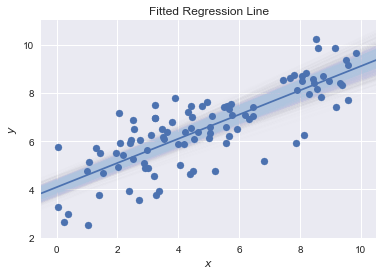

In [15]:
# Plotting regression line
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
np.random.shuffle(alpha), np.random.shuffle(beta)
for i in range(1000):
    plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', 
           alpha=0.005 )

# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)
plt.show()

## Plotting the posteriors
Rather than restricting our analysis to summary statistics, we can also look in more detail at the series of sampled values for each parameter that we extracted previously. This will allow more insight into the sampling process and is an important part of performing fit diagnostics.

In [16]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    plt.gcf().tight_layout()
    plt.legend()

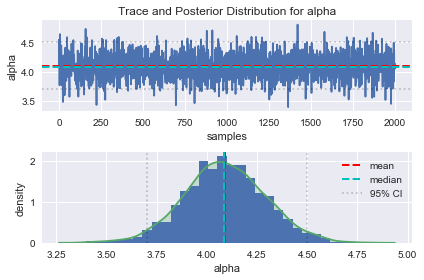

In [17]:
plot_trace(alpha, param_name='alpha')

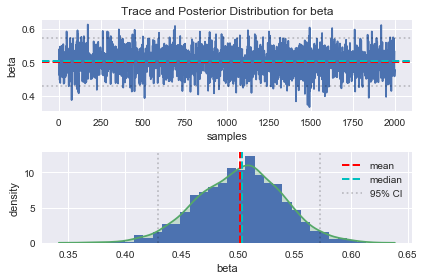

In [18]:
plot_trace(beta, param_name='beta')

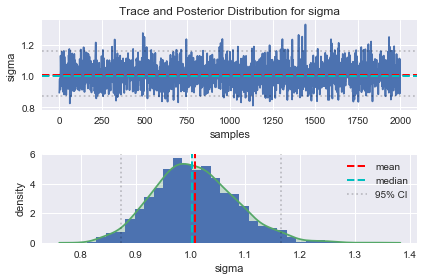

In [19]:
plot_trace(sigma, param_name='sigma')

We can see from the plots of the posterior distributions that the ground truths are on the whole pretty close to the modes of our distributions, and comfortably within the 95% credible intervals. There is some bias between the peaks of the posteriors and the ground truths, which is introduced as a result of the noise in the data. The handy thing about the Bayesian approach is that the uncertainty in estimation is captured in the spread of these posteriors, and can be improved by providing more insightful priors.

## Conclusions
So we’ve seen how to write a model in Stan, perform sampling using generated data in PyStan, and examine the outputs of the sampling process. Bayesian inference can be extremely powerful, and there are many more features of Stan that remain to be explored. I hope this example has been useful and that you can use some of this material in performing your own sampling and inference.

Credit goes to: https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53